# Лекция 13. Межпроцессное взаимодействие в сети - сокеты

1. Понятие сокетов
2. Программирование сокетов
3. Создание простого клиент-серверного приложения
4. Пример сервера с дуплексной связью

## 1. Понятие сокетов

Механизмы межпроцессного взаимодействия, которые мы рассмотрели, позволяют организовать взаимодействие между процессами, работающими на одной машине. Теперь рассмотрим сетевые механизмы IPC, которые позволяют взаимодействовать процессам, выполняющимся на разных машинах (объединенных в общую сеть).

Данные механизмы основаны на понятии **сокета**.

**Сокет (гнездо)** это двунаправленный канал обмена данными между двумя компьютерами в сети. Информация по сокету может передаваться в обоих направлениях — от сервера к клиенту и от клиента к серверу.

На самом деле интерфейс сетевых сокетов можно использовать для взаимодействий между процессами независимо от того, где они работают — на одной машине или на разных. Это было одной из основных целей при разработке интерфейса сокетов: один и тот же набор функций должен был использоваться как для внутримашинного, так и для межмашинного обмена данными. 

Подобно тому как для работы с файлами используют дескрипторы файлов, для работы с сокетами используют **дескрипторы сокетов**. 

В Linux дескрипторы сокетов реализованы так же, как дескрипторы файлов. В действительности большинство функций, работающих с дескрипторами файлов, таких как read или write, будут работать и с дескрипторами сокетов.
Создается дескриптор сокета с помощью системного вызова socket. Библиотечные функции, необходимые для работы с сокетами, описаны в заголовочном файле socket.h:

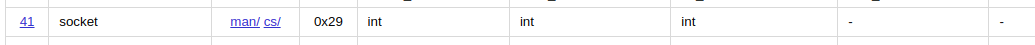

In [ ]:
#include <sys/socket.h>

int socket(int domain, int type, int protocol);

Данный системный вызов возвращает дескриптор сокета в случае успеха. 

Первый аргумент **domain** определяет используемое семейство адресов. В качестве значений могут быть следующие:

In [ ]:
/* Supported address families. */
#define AF_UNSPEC	0
#define AF_UNIX		1	/* Unix domain sockets 		*/
#define AF_INET		2	/* Internet IP Protocol 	*/
#define AF_AX25		3	/* Amateur Radio AX.25 		*/
#define AF_IPX		4	/* Novell IPX 			*/
#define AF_APPLETALK	5	/* Appletalk DDP 		*/
#define	AF_NETROM	6	/* Amateur radio NetROM 	*/
#define AF_BRIDGE	7	/* Multiprotocol bridge 	*/
#define AF_AAL5		8	/* Reserved for Werner's ATM 	*/
#define AF_X25		9	/* Reserved for X.25 project 	*/
#define AF_INET6	10	/* IP version 6			*/
#define AF_MAX		12	/* For now.. */

В аргументе **type** указывается тип сокета, который, в свою очередь, определяет характеристики взаимодействия. Он может принимать следующие значения:

In [ ]:
/* Socket types. */
#define SOCK_STREAM	1		/* stream (connection) socket	*/
#define SOCK_DGRAM	2		/* datagram (conn.less) socket	*/
#define SOCK_RAW	3		/* raw socket			*/
#define SOCK_RDM	4		/* reliably-delivered message	*/
#define SOCK_SEQPACKET	5		/* sequential packet socket	*/
#define SOCK_PACKET	10		/* linux specific way of	*/
					/* getting packets at the dev	*/
					/* level.  For writing rarp and	*/
					/* other similar things on the	*/
					/* user level.			*/


В аргументе **protocol** обычно передается значение 0, чтобы выбрать протокол по умолчанию для данного домена и типа сокета. Если для одного и того же домена и типа сокета поддерживается несколько протоколов, можно использовать этот
аргумент для выбора конкретного протокола. 

Протокол по умолчанию для сокетов типа SOCK_STREAM из домена AF_INET — TCP (Transmission Control Protocol — протокол управления передачей данных). 

Протокол по умолчанию для сокетов типа SOCK_DGRAM из домена AF_INET — UDP (User Datagram Protocol — протокол пользовательских дейтаграмм).

Протоколы указаны в файле /usr/include/netinet/in.h

In [ ]:
/* Standard well-defined IP protocols.  */
enum
  {
    IPPROTO_IP = 0,	   /* Dummy protocol for TCP.  */
#define IPPROTO_IP		IPPROTO_IP
    IPPROTO_ICMP = 1,	   /* Internet Control Message Protocol.  */
#define IPPROTO_ICMP		IPPROTO_ICMP
    IPPROTO_IGMP = 2,	   /* Internet Group Management Protocol. */
#define IPPROTO_IGMP		IPPROTO_IGMP
    IPPROTO_IPIP = 4,	   /* IPIP tunnels (older KA9Q tunnels use 94).  */
#define IPPROTO_IPIP		IPPROTO_IPIP
    IPPROTO_TCP = 6,	   /* Transmission Control Protocol.  */
#define IPPROTO_TCP		IPPROTO_TCP
    IPPROTO_EGP = 8,	   /* Exterior Gateway Protocol.  */
#define IPPROTO_EGP		IPPROTO_EGP
    IPPROTO_PUP = 12,	   /* PUP protocol.  */
#define IPPROTO_PUP		IPPROTO_PUP
    IPPROTO_UDP = 17,	   /* User Datagram Protocol.  */
#define IPPROTO_UDP		IPPROTO_UDP
    IPPROTO_IDP = 22,	   /* XNS IDP protocol.  */
#define IPPROTO_IDP		IPPROTO_IDP
    IPPROTO_TP = 29,	   /* SO Transport Protocol Class 4.  */
#define IPPROTO_TP		IPPROTO_TP
    IPPROTO_DCCP = 33,	   /* Datagram Congestion Control Protocol.  */
#define IPPROTO_DCCP		IPPROTO_DCCP
    IPPROTO_IPV6 = 41,     /* IPv6 header.  */
#define IPPROTO_IPV6		IPPROTO_IPV6
    IPPROTO_RSVP = 46,	   /* Reservation Protocol.  */
#define IPPROTO_RSVP		IPPROTO_RSVP
    IPPROTO_GRE = 47,	   /* General Routing Encapsulation.  */
#define IPPROTO_GRE		IPPROTO_GRE
    IPPROTO_ESP = 50,      /* encapsulating security payload.  */
#define IPPROTO_ESP		IPPROTO_ESP
    IPPROTO_AH = 51,       /* authentication header.  */
#define IPPROTO_AH		IPPROTO_AH
    IPPROTO_MTP = 92,	   /* Multicast Transport Protocol.  */
#define IPPROTO_MTP		IPPROTO_MTP
    IPPROTO_BEETPH = 94,   /* IP option pseudo header for BEET.  */
#define IPPROTO_BEETPH		IPPROTO_BEETPH
    IPPROTO_ENCAP = 98,	   /* Encapsulation Header.  */
#define IPPROTO_ENCAP		IPPROTO_ENCAP
    IPPROTO_PIM = 103,	   /* Protocol Independent Multicast.  */
#define IPPROTO_PIM		IPPROTO_PIM
    IPPROTO_COMP = 108,	   /* Compression Header Protocol.  */
#define IPPROTO_COMP		IPPROTO_COMP
    IPPROTO_SCTP = 132,	   /* Stream Control Transmission Protocol.  */
#define IPPROTO_SCTP		IPPROTO_SCTP
    IPPROTO_UDPLITE = 136, /* UDP-Lite protocol.  */
#define IPPROTO_UDPLITE		IPPROTO_UDPLITE
    IPPROTO_MPLS = 137,    /* MPLS in IP.  */
#define IPPROTO_MPLS		IPPROTO_MPLS
    IPPROTO_RAW = 255,	   /* Raw IP packets.  */
#define IPPROTO_RAW		IPPROTO_RAW
    IPPROTO_MAX
  };

При использовании интерфейса **дейтаграмм (SOCK_DGRAM)** не требуется устанавливать логическое соединение, чтобы обмениваться данными между конечными точками взаимодействия. Все, что нужно сделать, — передать сообщение по адресу сокета, который используется процессом на другом конце. Поэтому дейтаграммы представляют службу, не ориентированную на установление логического соединения. Передача дейтаграммы напоминает отправку письма по почте. Можно отправить множество писем, но нельзя гарантировать, что они будут доставлены в определенном порядке и что некоторые из них не потеряются по дороге. Каждое письмо содержит адрес
получателя, благодаря чему оно не зависит от других писем.

**Потоки байтов (SOCK_STREAM)**, с другой стороны, требуют, чтобы перед началом обмена данными между нашим сокетом и сокетом,
принадлежащим сетевому узлу, с которым предполагается взаимодействовать, было установлено логическое соединение. Протоколы, ориентированные на создание логического соединения, организованы как телефонный звонок. Прежде всего необходимо установить соединение, набрав номер телефона, и после того, как соединение будет установлено, оно обеспечивает двунаправленную связь с удаленным абонентом. Соединение обеспечивается одноранговым коммуникационным каналом. Такого рода соединение, через которое вы имеете возможность общаться, является соединением типа «точка-точка». Ваши слова не содержат адресной информации, так как подключение этого типа логически связывает оба конца коммуникационного канала и само по себе подразумевает однозначную идентификацию отправителя и получателя.

При использовании сокетов типа SOCK_STREAM приложения не распознают границ отдельных сообщений, поскольку сокеты такого типа реализуют услугу передачи потока байтов. Это означает, что операция чтения данных из сокета может вернуть не то количество байтов, которое было записано передающим процессом. В конечном счете будет получено все, что было отправлено, но для этого может потребоваться несколько вызовов функций.

**Сокеты типа SOCK_SEQPACKET** очень похожи на сокеты типа SOCK_STREAM, за исключением того, что вместо услуги приема/передачи данных в виде потока байтов они реализуют услугу передачи отдельных сообщений. Это означает, что объем данных, полученных из сокета типа SOCK_SEQPACKET, всякий раз в точности совпадает с объемом отправленных данных. Служба передачи последовательности пакетов в домене Интернета реализуется на базе протокола SСTP (Stream Control Transmission Protocol — протокол передачи с управлением потоком).

**Сокеты типа SOCK_RAW** представляют интерфейс дейтаграмм на сетевом уровне (то есть интерфейс к протоколу IP в домене Интернета). При использовании этого интерфейса вся ответственность за построение заголовков пакетов возлагается на приложения, поскольку сокеты этого типа не используют протоколы транспортного уровня (такие, как TCP или UDP). Чтобы предотвратить использование сокетов типа SOCK_RAW в неблаговидных целях, для их создания приложение должно обладать привилегиями суперпользователя.

Вызов функции **socket** напоминает вызов функции **open**. В обоих случаях мы получаем дескриптор файла, который затем используется в операциях ввода/вывода. По окончании работы с сокетом вызывается функция close, которая закрывает соединение и освобождает номер дескриптора для повторного использования.

Хотя дескриптор сокета является файловым дескриптором, его можно использовать не во всех функциях, которые принимают дескриптор файла. Например, функция **lseek** не может работать с сокетами, поскольку сокеты не поддерживают понятие текущей позиции в файле.

Ниже представлен пример программы открытия сокета.

In [ ]:
;;open_sock_1.asm

;;SOCK_STREAM
;;

format elf64
public _start
include 'func.asm'

section '.bss' writable

    buffer rb 100

section '.text' executable

_start:

    ;;Создаем сокет
    mov rdi, 2 ;AF_INET - IP v4 
    mov rsi, 1 ;SOCK_STREAM
    mov rdx, 6 ;TCP
    mov rax, 41
    syscall
    
    ;;Печатаем дескриптор сокета
    mov rsi, buffer
    call number_str
    call print_str
    call new_line
    
    call exit

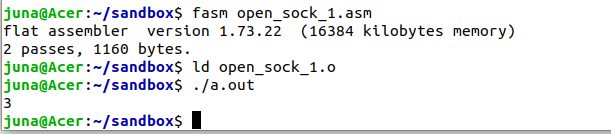

Обмен данными через сокеты является двунаправленным. Выполнение отдельных операций над сокетами можно запретить с помощью функции **shutdown**:

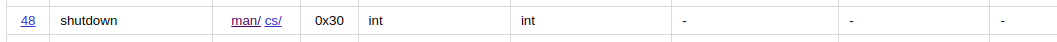

In [ ]:
#include <sys/socket.h>

int shutdown(int sockfd, int how);

Первый параметр **sockfd** - дескриптор сокета, второй параметр **how** может быть одной из констант:
- **SHUT_RD** - запрет чтения из сокета. 
- **SHUT_WR** - запрет записи в сокет.
- **SHUT_RDWR**  - запрет и чтения, и записи.
Константы **SHUT_RD , SHUT_WR , SHUT_RDWR** имеют значения 0, 1, 2, соответственно, и определены в <sys/socket.h>.

Иногда файловый дескриптор или дескриптор сокета следует копировать. В этом случае новый файловый или сокетный дескриптор ссылается на тот же самый объект. Копию можно сделать с помощью системного вызова **dup**

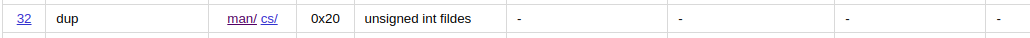

На входе задается дескриптор, копию которого мы хотим сделать. 

Завершить работу с сокетом - закрыть сокет можно с помощью системного вызовова **close**. Функция **close** закрывает соединение и освобождает дескриптор, только когда будет закрыта последняя активная ссылка на сокет. Это означает, что если мы создали дубликат дескриптора сокета (например, с помощью функции dup), функция close не сможет закрыть сокет, пока не будет закрыт последний дескриптор, ссылающийся на него. 

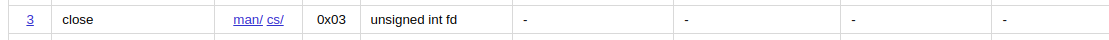

Ниже представлена программа, в которой создается сокет, дублируется его файловый дескриптор, далее регулируются права на чтение, запись из сокета, после чего каждый из них закрывается.

In [ ]:
;;open_sock_2.asm

format elf64
public _start
include 'func.asm'

section '.bss' writable

    buffer rb 100

section '.text' executable

_start:

    ;;Создаем сокет
    mov rdi, 2 ;AF_INET - IP v4 
    mov rsi, 1 ;SOCK_STREAM
    mov rdx, 6 ;TCP
    mov rax, 41
    syscall
    
    ;;Сохраняем дескриптор сокета
    mov r9, rax
    
    mov rsi, buffer
    call number_str
    call print_str
    call new_line
    
    ;;Дублируем сокет
    mov rdi, r9
    mov rax, 32
    syscall
    
    ;;Сохраняем второй дескриптор сокета
    mov r10, rax
    
    mov rsi, buffer
    call number_str
    call print_str
    call new_line
    
    ;;Изменяем права доступа к сокету
    mov rdi, r9
    mov rsi, 0 ;;Запрет на чтение
    mov rax, 48
    syscall
    
    mov rdi, r10
    mov rsi, 1 ;;Запрет на запись
    mov rax, 48
    syscall 
    
    ;;Закрываем сокет
    
    mov rdi, r9
    mov rax, 3
    syscall
    
    mov rdi, r10
    mov rax, 3
    syscall
    
    call exit

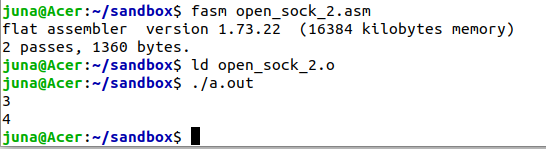

Конечно, полноценная работа с сокетом возможна, когда мы свяжем его с конкретным IP адресом и портом. Это можно сделать системным вызовом **bind**:

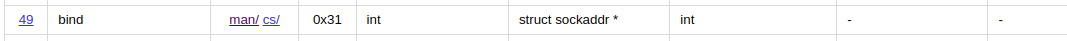

In [ ]:
#include <sys/socket.h>
int bind(int sockfd, const struct sockaddr *addr, socklen_t addrlen);


На вход поступает три параметра: 
- первый параметр - дескриптор сокета;
- второй параметр - специальная структура, определяющая адрес сокета;
- третий параметр - длина адресной структуры.

Каждый домен сокета имеет свой формат представления адреса и следовательно структуру адреса. При задании адреса важно также учитывать порядок байтов — это характеристика аппаратной архитектуры, определяющая, в каком порядке следуют байты в данных длинных типов, таких как целые числа. Если архитектура поддерживает прямой (big-endian) порядок байтов, в старшем
адресе будет располагаться младший значащий байт. В случае обратного (little-endian) порядка байтов младший значащий байт будет храниться в младшем адресе.

Чтобы не возникало путаницы с порядком байтов при обмене данными между разнородными компьютерными системами, сетевые протоколы жестко задают порядок байтов. **Набор протоколов TCP/IP использует сетевой (прямой, big-endian) порядок байтов**. Порядок байтов приобретает важность, когда приложения начинают обмениваться форматированными данными. При использовании протоколов TCP/IP адреса имеют сетевой порядок байтов, поэтому в приложениях иногда возникает необходимость преобразовать порядок байтов, поддерживаемый
аппаратной архитектурой, в сетевой порядок байтов.

Все структуры типа sockaddr определены в файле socket.h (/usr/incude/sys/socket.h):

In [ ]:
# define __SOCKADDR_ALLTYPES \
 __SOCKADDR_ONETYPE (sockaddr) \
 __SOCKADDR_ONETYPE (sockaddr_at) \
 __SOCKADDR_ONETYPE (sockaddr_ax25) \
 __SOCKADDR_ONETYPE (sockaddr_dl) \
 __SOCKADDR_ONETYPE (sockaddr_eon) \
 __SOCKADDR_ONETYPE (sockaddr_in) \
 __SOCKADDR_ONETYPE (sockaddr_in6) \
 __SOCKADDR_ONETYPE (sockaddr_inarp) \
 __SOCKADDR_ONETYPE (sockaddr_ipx) \
 __SOCKADDR_ONETYPE (sockaddr_iso) \
 __SOCKADDR_ONETYPE (sockaddr_ns) \
 __SOCKADDR_ONETYPE (sockaddr_un) \
 __SOCKADDR_ONETYPE (sockaddr_x25)

Нас интересует структура sockaddr_in, подходящая для TCP/IPv4.

Адрес IP-сокета определяется как комбинация IP-адреса,  адреса интерфейса и 16-битный номер порта. 

In [ ]:
struct sockaddr_in {
               sa_family_t    sin_family; /* address family: AF_INET */
               in_port_t      sin_port;   /* port in network byte order */
               struct in_addr sin_addr;   /* internet address */
           };

Под портом понимают некоторое неотрицательное число, которое используется для разделения запросов разных процессов, работающих на одном и том же хосте. Номер порта должен находиться в диапазоне от 1 до $2^{16}-1 = 65535$. Однако порты в диапазоне от 1 до 1024 можно использовать только в привилегированном режиме.

В ассемблере такую структуру можно определить следующим образом:

In [ ]:
Struc sockaddr_in
{
  .sin_family, dw 2         ; AF_INET
  .sin_port, dw 5555        ; port 5555
  .sin_addr, dd 0           ; localhost
  .sin_zero, dd 0, 0
}
addrlen = $ - sockaddr_in

В случае успеха **bind** возвращает 0, иначе код ошибки.

Ниже представлена программа, в которой сокет именуется с использованием **bind**.

In [ ]:
;;bind_sock.asm

format elf64
public _start
include 'func.asm'

section '.data' writeable
  
  msg_1 db 'Error bind', 0xa, 0
  msg_2 db 'Successfull bind', 0xa, 0

section '.bss' writable

  buffer rb 100

  struc sockaddr_in
{
  .sin_family dw 2         ; AF_INET
  .sin_port dw 0x3d9         ; port 55555
  .sin_addr dd 0          ; localhost
  .sin_zero_1 dd 0
  .sin_zero_2 dd 0
}

  addrstr sockaddr_in 
  addrlen = $ - addrstr


section '.text' executable

_start:

    ;;Создаем сокет
    mov rdi, 2 ;AF_INET - IP v4 
    mov rsi, 1 ;SOCK_STREAM
    mov rdx, 6 ;TCP
    mov rax, 41
    syscall
    
    ;;Сохраняем и печатаем дескриптор сокета
    mov r9, rax
    
    mov rsi, buffer
    call number_str
    call print_str
    call new_line
    
       
    ;;Связываем сокет с адресом
    
    mov        rax, 49              ; SYS_BIND
    mov        rdi, r9              ; listening socket fd
    mov        rsi, addrstr        ; sockaddr_in struct
    mov        rdx, addrlen         ; length of sockaddr_in
    syscall

    ;; Проверяем успешность вызова
    cmp        rax, 0
    jl         _bind_error
    
    mov rsi, msg_2
    call print_str
    
    ;;Закрываем сокет
    
    mov rdi, r9
    mov rax, 3
    syscall
    
    call exit
    
_bind_error:
   mov rsi, msg_1
   call print_str
   call exit

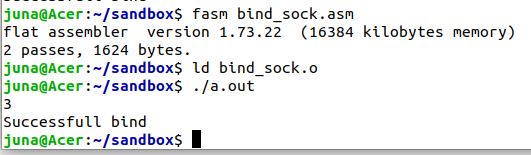

В предложенном коде следует обратить внимание, как задан адрес порта 55555:

In [3]:
hex(55555)

'0xd903'

Поскольку в сетевом адресе принят прямой порядок: в старшем адресе будет располагаться младший значащий байт, то в структуре нужно указывать перевернутую комбинацию: 0x3d9.

# 2. Программирование сокетов

После того как сокет создан и связан с адресом и портом, можно установить связь с удаленным компьютером. На стороне клиента используется только функция connect(), а на стороне сервера могут использоваться listen() и accept(). Первая ждет клиента,
а вторая — подтверждает запрос клиента на установку соединения.

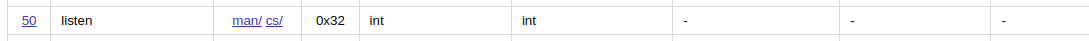

In [ ]:
#include <sys/socket.h>

int listen(int sockfd, int backlog);

**listen** отмечает сокет, на который ссылается sockfd, как пассивный сокет, то есть как сокет, который будет использоваться для приема входящих запросов на подключение с использованием **accept** (это характерно для сервера).

Аргумент **sockfd** — это дескриптор, ссылающийся на сокет типа SOCK_STREAM или SOCK_SEQPACKET .

Аргумент **backlog** определяет максимальную длину, до которой очередь ожидающих соединений для sockfd может вырасти (максимальное количество клиентов). 

В случае успеха функция **listen** возвращается 0. 

После вызова функции **listen** указанный сокет будет использоваться для приема запросов на соединение. Функция **accept** принимает запрос и преобразует его в соединение.

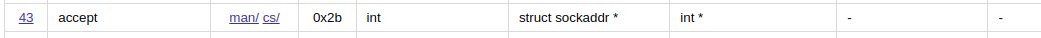

In [ ]:
#include <sys/socket.h>
int accept(int sockfd, struct sockaddr *restrict addr, socklen_t *restrict len);

Первый параметр — это дескриптор сокета, второй — это указатель на структуру, в которой можно разместить адрес клиента, третий - указатель на длину этой структуры.

**Функция accept возвращает дескриптор сокета, соединенного с клиентом, вызвавшим функцию connect. Этот новый сокет имеет тот же тип и семейство адресов, что и сокет sockfd.** 

**Первоначальный сокет, который передается функции accept, не связан с установленным соединением, он остается свободным для приема последующих запросов на соединение.**

Если информация о клиенте не нужна, мы можем передать в аргументах **addr** и **len** значение **NULL**. Иначе необходимо передать в addr адрес буфера достаточного размера для хранения адреса, а в аргументе len — адрес целого числа, определяющего размер буфера. 

По возвращении из функции **accept** в буфере будет находиться адрес клиента, а по адресу **len** — фактический размер адреса.
Если запросы, ожидающие обработки, отсутствуют, функция **accept** будет заблокирована, пока не поступит хотя бы один запрос. Если **sockfd** находится в неблокирующем режиме, функция accept вернет значение -1.

Напишем программу, которая будет выполнять роль сервера. К ней можно подключиться с помощью внешнего клиента, например, **telnet**.  Сервер фиксирует соединение и разрывает его, он работает в цикле, продолжая слушать порт сокета.

In [ ]:
;;listen_accept_1.asm

format elf64
public _start
include 'func.asm'

section '.data' writeable
  
  msg_1 db 'Error bind', 0xa, 0
  msg_2 db 'Successfull bind', 0xa, 0
  msg_3 db 'New connection', 0xa, 0
  msg_4 db 'Successfull listen', 0xa, 0

section '.bss' writable

  buffer rb 100

  struc sockaddr_in
{
  .sin_family dw 2         ; AF_INET
  .sin_port dw 0x3d9     ; port 55555
  .sin_addr dd 0           ; localhost
  .sin_zero_1 dd 0
  .sin_zero_2 dd 0
}

  addrstr sockaddr_in 
  addrlen = $ - addrstr

section '.text' executable

_start:

    ;;Создаем сокет
    mov rdi, 2 ;AF_INET - IP v4 
    mov rsi, 1 ;SOCK_STREAM
    mov rdx, 6 ;TCP
    mov rax, 41
    syscall
    
    ;;Сохраняем дескриптор сокета
    mov r9, rax
    
    mov rsi, buffer
    call number_str
    call print_str
    call new_line
    
       
    ;;Связываем сокет с адресом
    
    mov        rax, 49              ; SYS_BIND
    mov        rdi, r9              ; дескриптор сервера
    mov        rsi, addrstr        ; sockaddr_in struct
    mov        rdx, addrlen         ; length of sockaddr_in
    syscall

    ;; Проверяем успешность вызова
    cmp        rax, 0
    jl         _bind_error
    
    mov rsi, msg_2
    call print_str
    
    ;;listen
    mov rax, 50 ;sys_listen
    mov rdi, r9 ;дескриптор
    mov rsi, 3  ; количество клиентов
    syscall
    cmp rax, 0
    jl  _bind_error
    
    mov rsi, msg_4
    call print_str
    
    .main_loop:
      
      ;;accept
      mov rax, 43
      mov rdi, r9
      mov rsi, 0
      mov rdx, 0
      syscall
      
      ;;Сохраняем дескриптор сокета клиента
      mov r12, rax
      
      ;;Печатаем сообщение о подключении
      mov rsi, msg_3
      call print_str
      
      ;;Закрываем сокет
      mov rdi, r12
      mov rax, 3
      syscall
      
     jmp .main_loop
    
_bind_error:
   mov rsi, msg_1
   call print_str
   call exit

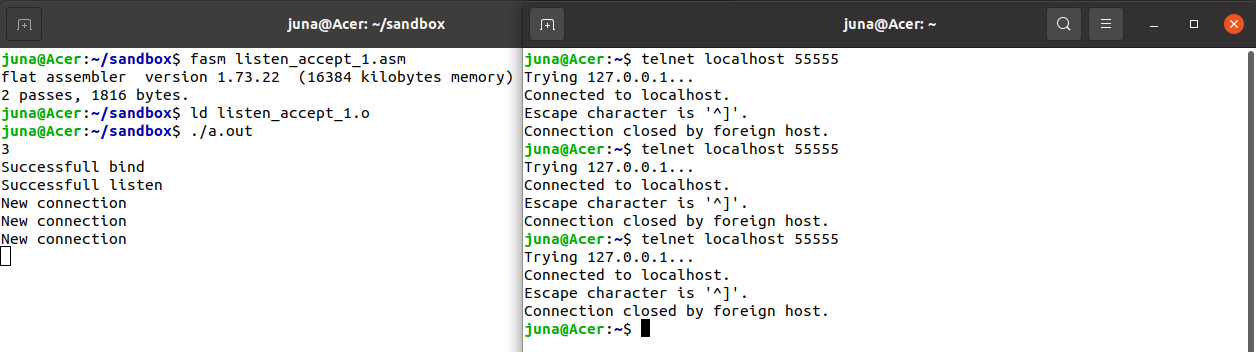

Из представленного скриншота видно, что каждое подключение фиксируется на сервере.

Заметим, что с помощью утилиты **netstat** удобно смотреть информацию о портах, которые кто-либо слушает в системе:

> netstat -l  ;Все прослушиваемые порты

> netstat -lt ;Все прослушиваемые TCP порты

> netstat -lu ;Все прослушиваемые UDP порты

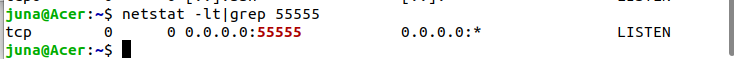

Также нужно заметить, что для доступа к портам, они не должны быть закрыты firewall:

> systemctl status firewalld

> systemctl stop firewalld

> systemctl start firewalld

Со стороны клиента должна работать всего одна функция: **connect**. Она используется на стороне клиента для отправки запроса на подключение к серверу.

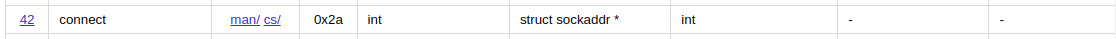

In [ ]:
#include <sys/socket.h>

int connect(int sockfd, const struct sockaddr *addr, socklen_t addrlen);

Как видно, структура параметров здесь точно такая же, как в функции **bind**: первый параметр — это дескриптор сокета клиента, второй — структура с адресом сервера (и номером порта сервера), а третий — длина структуры, указанной во втором параметре.

В случае успеха функция возвращает 0.


Напишем клиента, который подключится к нашему серверу. Пусть клиент работает на порту 55556.

In [ ]:
;;client_connect.asm

format elf64
public _start
include 'func.asm'

section '.data' writeable
  
  msg_1 db 'Error bind', 0xa, 0
  msg_2 db 'Successfull bind', 0xa, 0
  msg_3 db 'Successful connect', 0xa, 0
  msg_4 db 'Error connect', 0xa, 0

section '.bss' writable

  buffer rb 100
  

struc sockaddr_client
{
  .sin_family dw 2         ; AF_INET
  .sin_port dw 0x4d9     ; port 55556
  .sin_addr dd 0           ; localhost
  .sin_zero_1 dd 0
  .sin_zero_2 dd 0
}

addrstr_client sockaddr_client 
addrlen_client = $ - addrstr_client
  
struc sockaddr_server 
{
  .sin_family dw 2         ; AF_INET
  .sin_port dw 0x3d9     ; port 55555
  .sin_addr dd 0           ; localhost
  .sin_zero_1 dd 0
  .sin_zero_2 dd 0
}

addrstr_server sockaddr_server 
addrlen_server = $ - addrstr_server

section '.text' executable

_start:

    ;;Создаем сокет клиента
    mov rdi, 2 ;AF_INET - IP v4 
    mov rsi, 1 ;SOCK_STREAM
    mov rdx, 6 ;TCP
    mov rax, 41
    syscall
    
    ;;Сохраняем дескриптор сокета клиента
    mov r9, rax
    
       
    ;;Связываем сокет с адресом
    
    mov rax, 49              ; SYS_BIND
    mov rdi, r9              ; дескриптор сервера
    mov rsi, addrstr_client  ; sockaddr_in struct
    mov rdx, addrlen_client  ; length of sockaddr_in
    syscall

    ;; Проверяем успешность вызова
    cmp        rax, 0
    jl         _bind_error
    
    mov rsi, msg_2
    call print_str
    
    ;;Подключаемся к серверу
    mov rax, 42 ;sys_connect
    mov rdi, r9 ;дескриптор
    mov rsi, addrstr_server 
    mov rdx, addrlen_server
    syscall
    
    cmp rax, 0
    jl  _connect_error
    
    mov rsi, msg_3
    call print_str
    
    ;;Закрываем чтение, запись из клиентского сокета
    mov rax, 48
    mov rdi, r9
    mov rsi, 2
    syscall
          
    ;;Закрываем клиентский сокет
    mov rdi, r9
    mov rax, 3
    syscall
    
    call exit
    
_bind_error:
   mov rsi, msg_1
   call print_str
   call exit
   
_connect_error:
   mov rsi, msg_4
   call print_str
   call exit

Также перепишем наш сервер так, чтобы он выводил порт, по которому произошло подключение.

In [ ]:
;;server.asm

format elf64
public _start
include 'func.asm'

section '.data' writeable
  
  msg_1 db 'Error bind', 0xa, 0
  msg_2 db 'Successfull bind', 0xa, 0
  msg_3 db 'New connection on port ', 0
  msg_4 db 'Successfull listen', 0xa, 0

section '.bss' writable

  buffer rb 100


;;Зарезервированная область памяти под параметры адреса клиента
 client rb 16 
 len_client rq 1

;;Структура для клиента
  struc sockaddr_in
{
  .sin_family dw 2         ; AF_INET
  .sin_port dw 0x3d9     ; port 60000
  .sin_addr dd 0           ; localhost
  .sin_zero_1 dd 0
  .sin_zero_2 dd 0
}

  addrstr sockaddr_in 
  addrlen = $ - addrstr

section '.text' executable

_start:

    ;;Создаем сокет
    mov rdi, 2 ;AF_INET - IP v4 
    mov rsi, 1 ;SOCK_STREAM
    mov rdx, 6 ;TCP
    mov rax, 41
    syscall
    
    ;;Сохраняем дескриптор сокета
    mov r9, rax
    
    mov rsi, buffer
    call number_str
    call print_str
    call new_line
    
       
    ;;Связываем сокет с адресом
    
    mov        rax, 49              ; SYS_BIND
    mov        rdi, r9              ; дескриптор сервера
    mov        rsi, addrstr        ; sockaddr_in struct
    mov        rdx, addrlen         ; length of sockaddr_in
    syscall

    ;; Проверяем успешность вызова
    cmp        rax, 0
    jl         _bind_error
    
    mov rsi, msg_2
    call print_str
    
    ;;Запускаем прослушивание сокета
    mov rax, 50 ;sys_listen
    mov rdi, r9 ;дескриптор
    mov rsi, 10  ; количество клиентов
    syscall
    cmp rax, 0
    jl  _bind_error
    
    mov rsi, msg_4
    call print_str
    
    ;;Главный цикл ожидания подключений
    .main_loop:
      
      ;;accept
      mov rax, 43
      mov rdi, r9
      mov rsi, client
      mov rdx, len_client
      syscall
      
      ;;Сохраняем дескриптор сокета клиента
      mov r12, rax
      
      ;;Печатаем сообщение о подключении
      mov rsi, msg_3
      call print_str
      
      ;;Меняем прямое расположение значения порта в памяти
      xor rax, rax
      mov ax, word [client+2]
      mov dh, ah
      mov dl, al
      mov ah, dl
      mov al, dh
      mov rsi, buffer
      call number_str
      call print_str
      call new_line
      
      ;;Закрываем клиентский сокет на чтение, запись
      mov rax, 48
      mov rdi, r12
      mov rsi, 2
      syscall
      
      ;;Закрываем клиентский сокет
      mov rdi, r12
      mov rax, 3
      syscall
      
     jmp .main_loop
    
_bind_error:
   mov rsi, msg_1
   call print_str
   call exit

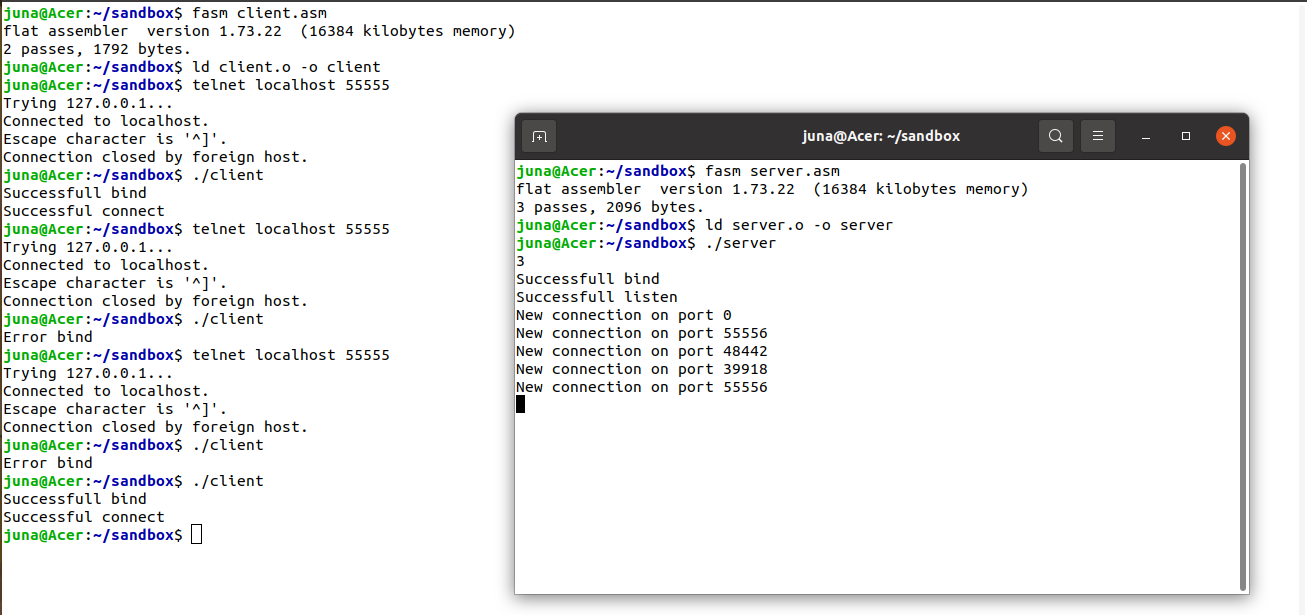

Здесь мы видим, что клиент **telnet** каждый раз подключается по случайному порту, в то время как наш клиент всегда по порту 55556. Это ему не всегда удается - если между последовательными отключениями - подключениями прошло мало времени, то ядро операционной системы не успевает освободить порт, и на этапе привязки к адресу возникает ошибка (Error bind). 

## 3. Создание простого клиент-серверного приложения

Научившись устанавливать соединение между сервером и клиентами, перейдем теперь к изучение вопросов обмена данными.

Поскольку сокет представлен файловым дескриптором, мы можем использовать функции **read и write**, когда он соединен с удаленной стороной.

Напишем простейшую связку приложений эхо-сервер и клиент: клиент посылает сообщения на сервер, а сервер повторяет их в своем терминале. 

Вначале просто дополним наш сервер системным вызовом чтения:

In [ ]:
;;server_2.asm

format elf64
public _start
include 'func.asm'

section '.data' writeable
  
  msg_1 db 'Error bind', 0xa, 0
  msg_2 db 'Successfull bind', 0xa, 0
  msg_3 db 'New connection on port ', 0
  msg_4 db 'Successfull listen', 0xa, 0

section '.bss' writable

  buffer rb 100

;;Структура для клиента
  struc sockaddr_in
{
  .sin_family dw 2         ; AF_INET
  .sin_port dw 0x3d9     ; port 60000
  .sin_addr dd 0           ; localhost
  .sin_zero_1 dd 0
  .sin_zero_2 dd 0
}

  addrstr sockaddr_in 
  addrlen = $ - addrstr

section '.text' executable

_start:

    ;;Создаем сокет
    mov rdi, 2 ;AF_INET - IP v4 
    mov rsi, 1 ;SOCK_STREAM
    mov rdx, 6 ;TCP
    mov rax, 41
    syscall
    
    ;;Сохраняем дескриптор сокета
    mov r9, rax
    
       
    ;;Связываем сокет с адресом
    
    mov rax, 49              ; SYS_BIND
    mov rdi, r9              ; дескриптор сервера
    mov rsi, addrstr        ; sockaddr_in struct
    mov rdx, addrlen         ; length of sockaddr_in
    syscall

    ;; Проверяем успешность вызова
    cmp        rax, 0
    jl         _bind_error
    
    mov rsi, msg_2
    call print_str
    
    ;;Запускаем прослушивание сокета
    mov rax, 50 ;sys_listen
    mov rdi, r9 ;дескриптор
    mov rsi, 10  ; количество клиентов
    syscall
    cmp rax, 0
    jl  _bind_error
    
    ;;Главный цикл ожидания подключений
    .main_loop:
      
      ;;accept
      mov rax, 43
      mov rdi, r9
      mov rsi, 0
      mov rdx, 0
      syscall
      
      ;;Сохраняем дескриптор сокета клиента
      mov r12, rax
      
      ;;Читаем сообшение от клиента
      mov rax, 0 ;номер системного вызова чтения
      mov rdi, r12 ;загружаем файловый дескриптор
      mov rsi, buffer ;указываем, куда помещать прочитанные данные
      mov rdx, 100 ;устанавливаем количество считываемых данных
      syscall ;выполняем системный вызов read
      
      call print_str
      
     jmp .main_loop
    
_bind_error:
   mov rsi, msg_1
   call print_str
   call exit

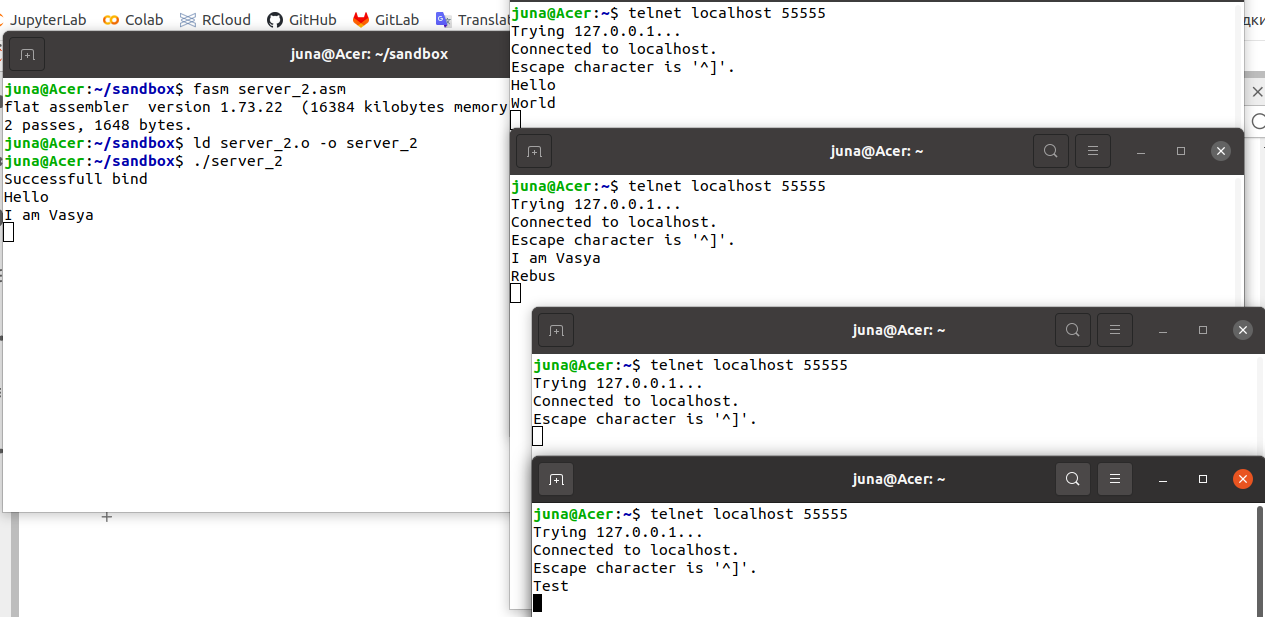

Из представленного скриншота видно, что сервер работает не совсем корректно. Он принимает от клиента только первое сообщение. А если клиент еще не успел прислать сообщение и подключился следующий, то этот следуюший не может прислать сообщения.

Все это легко объясняется - ведь на сервере после **accept** идет чтение сообщения от клиента, и файловый дескриптор не меняется.

На практике в таких ситуациях после подключения клиента создают **fork**, в котором и происходит дальнейшее независимое взаимодействие с клиентом.

Ниже представлена подобная доработка сервера.

In [ ]:
;;server_3.asm

format elf64
public _start
include 'func.asm'

section '.data' writeable
  
  msg_1 db 'Error bind', 0xa, 0
  msg_2 db 'Successfull bind', 0xa, 0
  msg_3 db 'New connection on port ', 0
  msg_4 db 'Successfull listen', 0xa, 0
  
section '.bss' writable

  buffer rb 100

;;Структура для клиента
  struc sockaddr_in
{
  .sin_family dw 2         ; AF_INET
  .sin_port dw 0x3d9     ; port 55555
  .sin_addr dd 0           ; localhost
  .sin_zero_1 dd 0
  .sin_zero_2 dd 0
}

  addrstr sockaddr_in 
  addrlen = $ - addrstr

section '.text' executable

_start:

    ;;Создаем сокет
    mov rdi, 2 ;AF_INET - IP v4 
    mov rsi, 1 ;SOCK_STREAM
    mov rdx, 6 ;TCP
    mov rax, 41
    syscall
    
    ;;Сохраняем дескриптор сокета
    mov r9, rax
    
       
    ;;Связываем сокет с адресом
    
    mov rax, 49              ; SYS_BIND
    mov rdi, r9              ; дескриптор сервера
    mov rsi, addrstr        ; sockaddr_in struct
    mov rdx, addrlen         ; length of sockaddr_in
    syscall

    ;; Проверяем успешность вызова
    cmp        rax, 0
    jl         _bind_error
    
    mov rsi, msg_2
    call print_str
    
    ;;Запускаем прослушивание сокета
    mov rax, 50 ;sys_listen
    mov rdi, r9 ;дескриптор
    mov rsi, 10  ; количество клиентов
    syscall
    cmp rax, 0
    jl  _bind_error
    
    ;;Главный цикл ожидания подключений
    .main_loop:
      
      ;;accept
      mov rax, 43
      mov rdi, r9
      mov rsi, 0
      mov rdx, 0
      syscall
      
      ;;Сохраняем дескриптор сокета клиента
      mov r12, rax
       
     ;;Делаем fork
     mov rax, 57
     syscall
   
     cmp rax,0
     je _read
      
     jmp .main_loop
    
_bind_error:
   mov rsi, msg_1
   call print_str
   call exit
   
_read:
      mov rax, 0 ;номер системного вызова чтения
      mov rdi, r12 ;загружаем файловый дескриптор
      mov rsi, buffer ;указываем, куда помещать прочитанные данные
      mov rdx, 100 ;устанавливаем количество считываемых данных
      syscall ;выполняем системный вызов read
      
      ;;Если клиент ничего не прислал (обрыв связи), завершаем его работу
      cmp rax, 0
      je .exit
      
      call print_str
      call new_line
      
      ;;Очищаем буффер, чтобы он не хранил старые значения
      mov rcx, 100
      mov rax, 0
      .lab:
        mov [buffer+rcx], 0
      loop .lab 
      jmp _read
    .exit:
      call exit

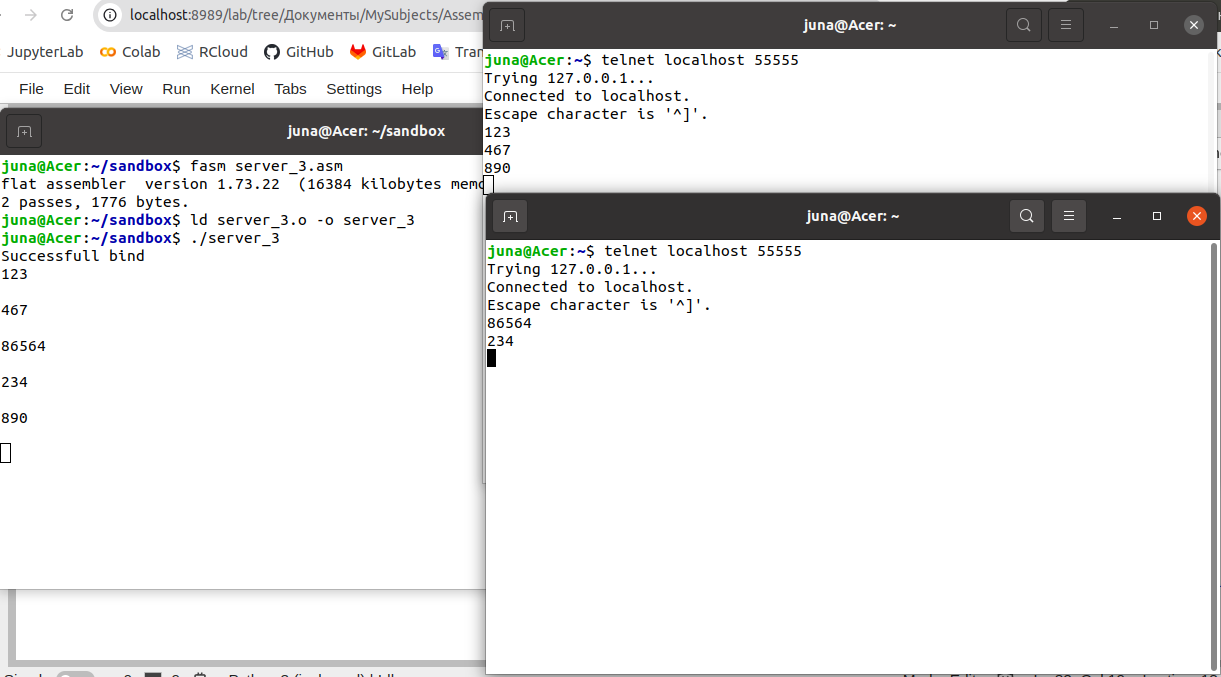

Из представленного скриншота видно, что взаимодействие между клиентом и сервером происходит асинхронно. Все сообщения от клиентов доставляются на сервер в заданной временной последовательности.

Доработаем также программу, реализующую функции клиента. Пусть он ожидает сообщения от пользователя, после чего отсылает его на сервер и завершает работу.

In [ ]:
;;client_2.asm

format elf64
public _start
include 'func.asm'

section '.data' writeable
  
  msg_1 db 'Error bind', 0xa, 0
  msg_2 db 'Successfull bind', 0xa, 0
  msg_3 db 'Successful connect', 0xa, 0
  msg_4 db 'Error connect', 0xa, 0

section '.bss' writable
	
  buffer rb 100
  

struc sockaddr_client
{
  .sin_family dw 2         ; AF_INET
  .sin_port dw 0x4d9     ; port 55556
  .sin_addr dd 0           ; localhost
  .sin_zero_1 dd 0
  .sin_zero_2 dd 0
}

addrstr_client sockaddr_client 
addrlen_client = $ - addrstr_client
  
struc sockaddr_server 
{
  .sin_family dw 2         ; AF_INET
  .sin_port dw 0x3d9     ; port 55555
  .sin_addr dd 0           ; localhost
  .sin_zero_1 dd 0
  .sin_zero_2 dd 0
}

addrstr_server sockaddr_server 
addrlen_server = $ - addrstr_server

section '.text' executable
	
_start:

    ;;Создаем сокет клиента
    mov rdi, 2 ;AF_INET - IP v4 
    mov rsi, 1 ;SOCK_STREAM
    mov rdx, 6 ;TCP
    mov rax, 41
    syscall
    
    ;;Сохраняем дескриптор сокета клиента
    mov r9, rax
    
       
    ;;Связываем сокет с адресом
    
    mov rax, 49              ; SYS_BIND
    mov rdi, r9              ; дескриптор сервера
    mov rsi, addrstr_client  ; sockaddr_in struct
    mov rdx, addrlen_client  ; length of sockaddr_in
    syscall

    ;; Проверяем успешность вызова
    cmp        rax, 0
    jl         _bind_error
    
    mov rsi, msg_2
    call print_str
    
    ;;Подключаемся к серверу
    mov rax, 42 ;sys_connect
    mov rdi, r9 ;дескриптор
    mov rsi, addrstr_server 
    mov rdx, addrlen_server
    syscall
    
    cmp rax, 0
    jl  _connect_error
    
    ;;Читаем сообщение с клавиатуры
    mov rsi, buffer
    call input_keyboard
    
    ;;Отправляем сообщение на сервер
    mov rax, 1
    mov rdi, r9
    mov rsi, buffer
    mov rdx, 100
    syscall
    
    ;;Закрываем чтение, запись из клиентского сокета
    mov rax, 48
    mov rdi, r9
    mov rsi, 2
    syscall
          
    ;;Закрываем клиентский сокет
    mov rdi, r9
    mov rax, 3
    syscall
    
    call exit

    
_bind_error:
   mov rsi, msg_1
   call print_str
   call exit
   
_connect_error:
   mov rsi, msg_4
   call print_str
   call exit

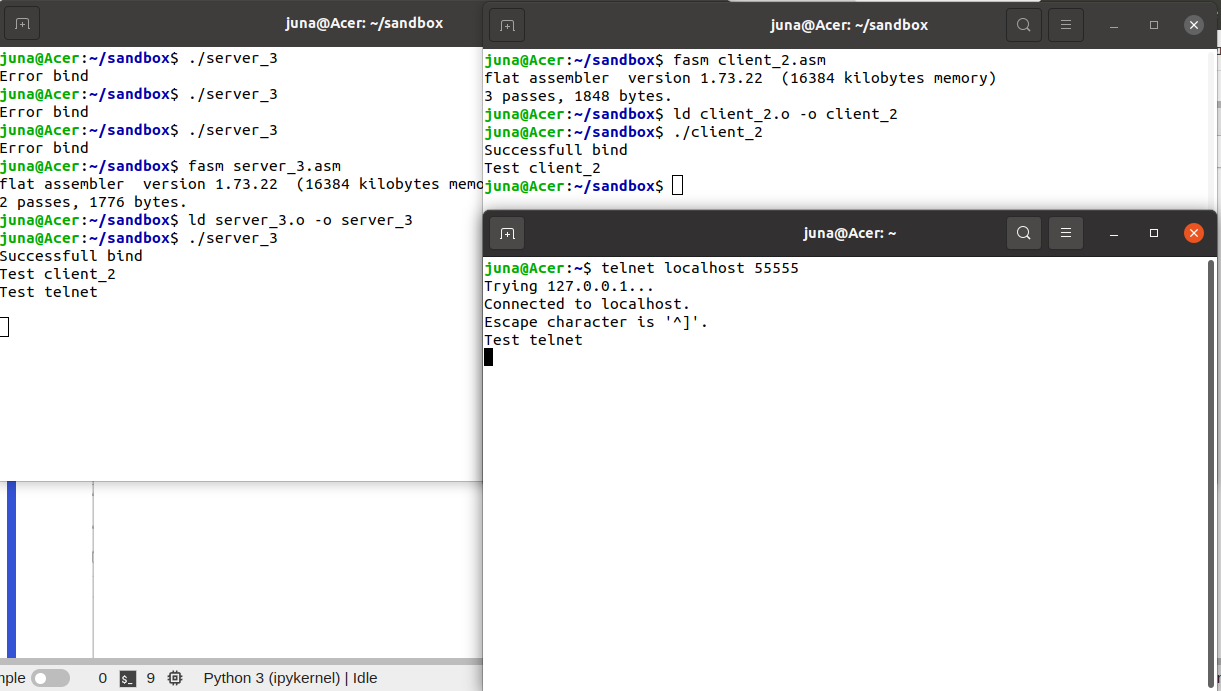

Из представленных скриншотов видно, что обеспечивается заданный функционал.

## 4. Пример сервера с дуплексной связью

In [ ]:
;;server_4.asm

format elf64
public _start
include 'func.asm'

section '.data' writeable
  
  msg_1 db 'Error bind', 0xa, 0
  msg_2 db 'Successfull bind', 0xa, 0
  msg_3 db 'New connection on port ', 0
  msg_4 db 'Successfull listen', 0xa, 0
  
section '.bss' writable

  buffer rb 100

;;Структура для клиента
  struc sockaddr_in
{
  .sin_family dw 2         ; AF_INET
  .sin_port dw 0x3d9     ; port 55555
  .sin_addr dd 0           ; localhost
  .sin_zero_1 dd 0
  .sin_zero_2 dd 0
}

  addrstr sockaddr_in 
  addrlen = $ - addrstr

section '.text' executable

_start:

    ;;Создаем сокет
    mov rdi, 2 ;AF_INET - IP v4 
    mov rsi, 1 ;SOCK_STREAM
    mov rdx, 6 ;TCP
    mov rax, 41
    syscall
    
    ;;Сохраняем дескриптор сокета
    mov r9, rax
    
       
    ;;Связываем сокет с адресом
    
    mov rax, 49              ; SYS_BIND
    mov rdi, r9              ; дескриптор сервера
    mov rsi, addrstr        ; sockaddr_in struct
    mov rdx, addrlen         ; length of sockaddr_in
    syscall

    ;; Проверяем успешность вызова
    cmp        rax, 0
    jl         _bind_error
    
    mov rsi, msg_2
    call print_str
    
    ;;Запускаем прослушивание сокета
    mov rax, 50 ;sys_listen
    mov rdi, r9 ;дескриптор
    mov rsi, 10  ; количество клиентов
    syscall
    cmp rax, 0
    jl  _bind_error
    
    ;;Главный цикл ожидания подключений
    .main_loop:
      
      ;;accept
      mov rax, 43
      mov rdi, r9
      mov rsi, 0
      mov rdx, 0
      syscall
      
      ;;Сохраняем дескриптор сокета клиента
      mov r12, rax
       
     ;;Делаем fork for read
   
     mov rax, 57
     syscall
   
     cmp rax,0
     je _read
     
     mov rax, 57
     syscall
   
     cmp rax,0
     je _write
      
     jmp .main_loop
    
_bind_error:
   mov rsi, msg_1
   call print_str
   call exit
   
_read:
      mov rax, 0 ;номер системного вызова чтения
      mov rdi, r12 ;загружаем файловый дескриптор
      mov rsi, buffer ;указываем, куда помещать прочитанные данные
      mov rdx, 100 ;устанавливаем количество считываемых данных
      syscall ;выполняем системный вызов read
      
      ;;Если клиент ничего не прислал, продолжаем
      cmp rax, 0
      je _read     
      call print_str
      call new_line
      
      ;;Очищаем буффер, чтобы он не хранил старые значения
      mov rcx, 100
      mov rax, 0
      .lab:
        mov [buffer+rcx], 0
      loop .lab 
jmp _read

_write:
     mov rsi, buffer
     call input_keyboard
    
    ;;Отправляем сообщение на клиенту
    mov rax, 1
    mov rdi, r12
    mov rsi, buffer
    mov rdx, 100
    syscall
jmp _write

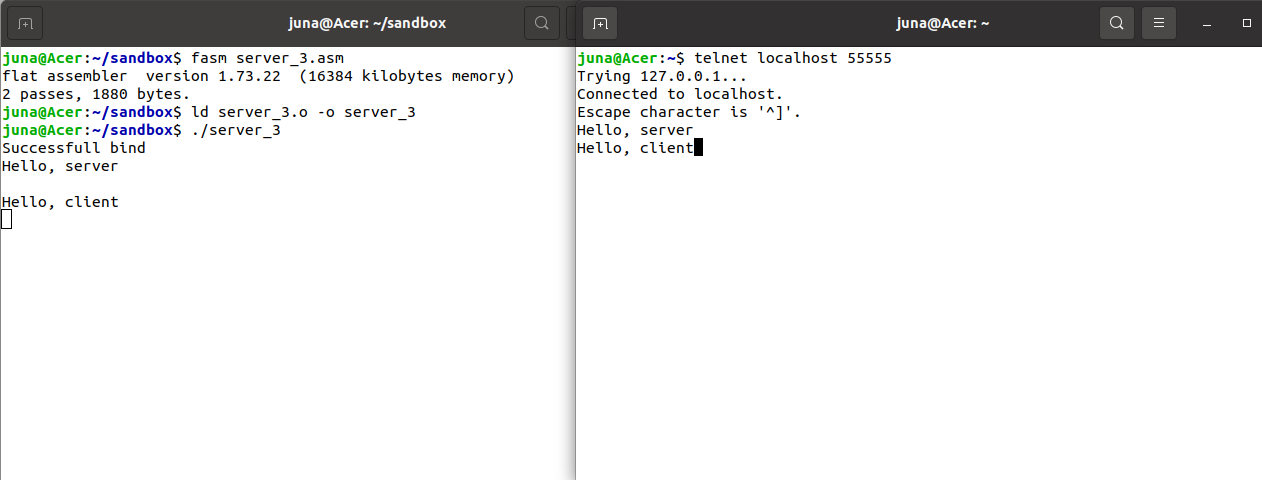